# Create configs:
1) Create a base config file:
    1) Define the covariates dict `COVARS`
    2) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
3) Iteratively increase or decrease a COV_TO_GEN relation and create multiple variations of the base config file.
    1) Define the number of steps of iteration
    2) Define the increment size
3) Test that the config file meets the expectation using `ToyBrainsData(config=...).show_current_config()`
4) Generate the datasets
5) For all covariates, estimate the maximum predictable accuracy from the generative attributes
    1) using linear/logistic regression model with $R^2$/$D^2$ metric for goodness-of-fit respectively.
    2) using SHAP
    3) by evaluating on a no-conf dataset variation and no-true signal dataset variation


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
import numpy as np
# from tqdm.notebook import tqdm
from copy import deepcopy

# if parent 'Toybrains' directory is not in path, add it
if os.path.abspath('../../') not in sys.path:
    sys.path.append(os.path.abspath('../../'))

from utils.vizutils import *
from utils.configutils import *

Define a simple case with 1 binary confound and 1 binary label:

In [3]:
# 1) Create a base config file:
#   a) Define the covariates dict `COVARS`
COVARS = {
            'cov_site'   : dict(states=['siteA', 'siteB']),
            'lbl_lesion' : dict(states=[True, False]),
         }
#   b) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
# Rules about which covariate-state influences which generative variables
RULES_COV_TO_GEN = {
    ## (1) c --> X: `siteA -> brain intensity is higher` 
    'cov_site':{
        'siteA':{ 
            'brain-int_fill'  :  dict(amt=(1,1,1,1,1)),
            ## (2) c --> y: `siteA -> more likely to be lesion group` 
            'lbl_lesion' : dict(idxs=(1),amt=(0))
        },
        'siteB':{
            'brain-int_fill'  : dict(amt=(1,1,1,1,1)),
            ## (2) c --> y: `siteB -> more likely to be control group` 
            'lbl_lesion' : dict(idxs=(0),amt=(0))
        },
    },
    
    ## (3) X --> y: `lbl_lesion is True -> Volume of mid-right lesion is higher`
    'lbl_lesion':{
        True:{  
            'shape-midr_curv'    :dict(amt=(1,1,1,1,1,1,1,1,1)), 
            'shape-midr_vol-rad' :dict(amt=(1,1,1,1))},
        False:{ 
            'shape-midr_curv'    :dict(amt=(1,1,1,1,1,1,1,1,1)),
            'shape-midr_vol-rad' :dict(amt=(1,1,1,1))},
    },
}

In [4]:
# ! rm -rf $config_dirname

In [5]:
basefilename = 'lblmidr-consite'
# create a folder to save all the configs
config_dirname = 'configs/'

if not os.path.exists(config_dirname):
    os.makedirs(config_dirname)

Sampling image gen. attributes for n=1000 toybrain samples


100%|██████████| 1000/1000 [00:02<00:00, 485.60it/s]


Config file: configs//lblmidr-consite.py


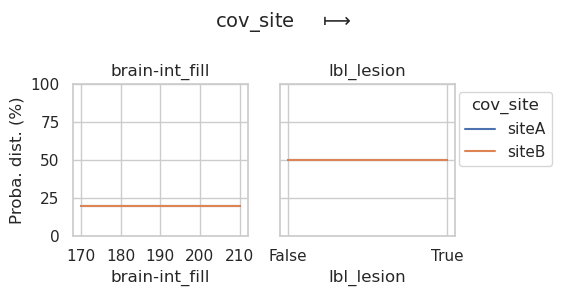

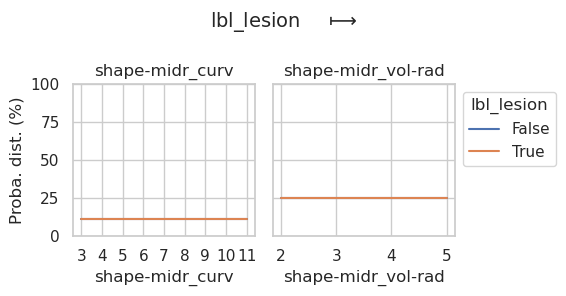

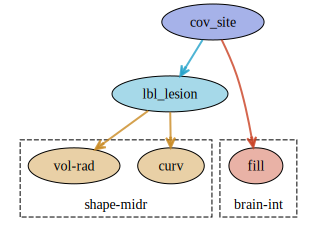

removed 'configs//lblmidr-consite.py'


In [6]:
# first create the base config file
config_fname = f'{config_dirname}/{basefilename}.py'
    
# see the base config file's causal graph
rules = deepcopy(RULES_COV_TO_GEN)
create_config_file(
                config_fname, COVARS, rules, 
                show_dag_probas=True,
                return_baseline_results = False,
                gen_images=0,
                overwrite_existing=True)

# delete the generated config file and dataset
!rm -v $config_fname
!rm -rf dataset/toybrains_n*$basefilename

### Define rule updates
Now iteratively generate more config files by:
1. incrementally increasing $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in 5 steps from 0% association to 100% association
2. incrementally increasing partial $c_{site} \rightarrow {brain-int\_fill}$ in 5 steps from 0 to 100% 
3. incrementally increasing partial $c_{site} \rightarrow y_{lesion}$ in 5 steps from 0 to 100% 

In [7]:
import math

def gen_yX_weights(arr, mul=1):
    return (np.arange(1, len(arr)+1, 1)*arr*mul).tolist()
    return new_arr

def gen_yX_weights_rev(arr, mul=1):
    return gen_yX_weights(arr[::-1], mul)[::-1]

In [8]:
# (1) incrementally increasing $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in 5 steps 
# from 0% association to 100% association
tweak_rules_yX =[
    ['lbl_lesion', True,   'shape-midr_curv',    'amt', gen_yX_weights],#lambda amt, i: gen_yX_weights(amt, mul=1)],
    ['lbl_lesion', True,   'shape-midr_vol-rad', 'amt', lambda amt: gen_yX_weights(amt, mul=2)],#lambda amt: gen_yX_weights(amt, mul=2)],
    ['lbl_lesion', False,  'shape-midr_curv',    'amt', gen_yX_weights_rev],#lambda amt: gen_yX_weights_rev(amt, mul=1)],
    ['lbl_lesion', False,  'shape-midr_vol-rad', 'amt', lambda amt: gen_yX_weights_rev(amt, mul=2)],#lambda amt: gen_yX_weights_rev(amt, mul=1)],
]
# test
test_tweak_rules(RULES_COV_TO_GEN, tweak_rules_yX, iters=5)

--------------------------------------------------
i=0
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = (1, 1, 1, 1, 1, 1, 1, 1, 1)
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = (1, 1, 1, 1)
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = (1, 1, 1, 1, 1, 1, 1, 1, 1)
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 amt = (1, 1, 1, 1)
--------------------------------------------------
i=1
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = [1, 2, 3, 4, 5, 6, 7, 8, 9]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = [2, 4, 6, 8]
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = [9, 8, 7, 6, 5, 4, 3, 2, 1]
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 amt = [8, 6, 4, 2]
--------------------------------------------------
i=2
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = [1, 4, 9, 16, 25, 36, 49, 64, 81]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = [4, 16, 36, 64]
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = [81, 64, 49, 36, 25, 16, 9, 4, 1]
	 lbl_lesion = False 	--> sh

In [9]:
# (2) incrementally increasing partial $c_{site} --> a_{brain-int_fill}$ in 5 steps from 0 to 100%
tweak_rules_cX =[
    ['cov_site', 'siteA', 'brain-int_fill', 'amt', lambda amt: gen_yX_weights(amt, mul=2)],
    ['cov_site', 'siteB', 'brain-int_fill', 'amt', lambda amt: gen_yX_weights_rev(amt, mul=2)]
]
test_tweak_rules(RULES_COV_TO_GEN, tweak_rules_cX)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> brain-int_fill:	 amt = (1, 1, 1, 1, 1)
	 cov_site = siteB 	--> brain-int_fill:	 amt = (1, 1, 1, 1, 1)
--------------------------------------------------
i=1
	 cov_site = siteA 	--> brain-int_fill:	 amt = [2, 4, 6, 8, 10]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [10, 8, 6, 4, 2]
--------------------------------------------------
i=2
	 cov_site = siteA 	--> brain-int_fill:	 amt = [4, 16, 36, 64, 100]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [100, 64, 36, 16, 4]
--------------------------------------------------
i=3
	 cov_site = siteA 	--> brain-int_fill:	 amt = [8, 64, 216, 512, 1000]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [1000, 512, 216, 64, 8]
--------------------------------------------------
i=4
	 cov_site = siteA 	--> brain-int_fill:	 amt = [16, 256, 1296, 4096, 10000]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [10000, 4096, 1296, 256, 16]


In [10]:
# (3) incrementally increasing partial $c_{site} --> y_{lesion}$ in 5 steps from 0 to 100% 
tweak_rules_cy =[
    ['cov_site', 'siteA', 'lbl_lesion', 'amt', lambda x: int((x+1)**2)],
    ['cov_site', 'siteB', 'lbl_lesion', 'amt', lambda x: int((x+1)**2)]
]
test_tweak_rules(RULES_COV_TO_GEN, tweak_rules_cy)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> lbl_lesion:	 amt = 0
	 cov_site = siteB 	--> lbl_lesion:	 amt = 0
--------------------------------------------------
i=1
	 cov_site = siteA 	--> lbl_lesion:	 amt = 1
	 cov_site = siteB 	--> lbl_lesion:	 amt = 1
--------------------------------------------------
i=2
	 cov_site = siteA 	--> lbl_lesion:	 amt = 4
	 cov_site = siteB 	--> lbl_lesion:	 amt = 4
--------------------------------------------------
i=3
	 cov_site = siteA 	--> lbl_lesion:	 amt = 25
	 cov_site = siteB 	--> lbl_lesion:	 amt = 25
--------------------------------------------------
i=4
	 cov_site = siteA 	--> lbl_lesion:	 amt = 676
	 cov_site = siteB 	--> lbl_lesion:	 amt = 676


### Generate all rules

In [11]:
N_SAMPLES  = 10000
GEN_BASELINES = True
GEN_IMAGES = True
OVERWRITE_EXISTING = False

In [12]:
# collect all the rules
all_rules = []
for cy in range(5):
    if cy==0:
        rules_cy = deepcopy(RULES_COV_TO_GEN)
    else:
        rules_cy = apply_tweak_rules(rules_cy, tweak_rules_cy)
    for cX in range(5):
        if cX==0: # reset the rules to previous loop's rules
            rules_cX = deepcopy(rules_cy)
        else:
            rules_cX = apply_tweak_rules(rules_cX, tweak_rules_cX)
        for yX in range(5):
            if yX==0: # reset the rules to previous loop's rules
                rules_yX = deepcopy(rules_cX)
            else:
                rules_yX = apply_tweak_rules(rules_yX, tweak_rules_yX)
            # print(f'cy={cy}, cX={cX}, yX={yX}, {rules_yX["lbl_lesion"][True]["shape-midr_curv"]["amt"]}')
            all_rules.append(((cy, cX, yX), deepcopy(rules_yX)))
        

### Generate datasets

In [13]:
def create_config_file_parallel(cy,cX,yX, rules, 
                                n_samples=N_SAMPLES, 
                                gen_baselines=GEN_BASELINES, gen_images=GEN_IMAGES):
    config_fname = f'{config_dirname}/{basefilename}_cy{cy}-cX{cX}-yX{yX}.py'
    print(f'Creating dataset: cy{cy}-cX{cX}-yX{yX}')
    
    # TODO: only generate images for one mid subset of settings to save time
    # if gen_images==True and cX==2: 
    #     gen_images = True
    # else:
    #     gen_images = False
        
    bl_result = create_config_file(
                    config_fname, COVARS, rules, 
                    show_dag_probas=False,
                    return_baseline_results=gen_baselines,
                    baseline_metrics=['balanced_accuracy', 'r2', 'roc_auc'],
                    n_samples=n_samples,
                    gen_images=gen_images,
                    verbose=0,
                    overwrite_existing=OVERWRITE_EXISTING)
    return bl_result

In [14]:
# test SHAP estimation
# (cy,cX,yX), rules = all_rules[-1]
# results = create_config_file_parallel(cy,cX,yX, rules)

In [15]:
# delete previously generated dataset
# stop da
# ! rm -rvf dataset/toybrains_n$N_SAMPLES_$basefilename_*

In [16]:
# parallelize the generation of configs using joblib
from joblib import Parallel, delayed
# print date and time
from datetime import datetime
print("Jobs started on {}".format(datetime.now()))

bl_results = Parallel(
    n_jobs=-1, verbose=0)(
                        delayed(
                            create_config_file_parallel)(
                                cy,cX,yX, r) for (cy,cX,yX), r in (all_rules))


Creating dataset: cy0-cX0-yX4
Config file 'configs//lblmidr-consite_cy0-cX0-yX4.py' already exists. Not overwriting it.
Creating dataset: cy0-cX0-yX3
Config file 'configs//lblmidr-consite_cy0-cX0-yX3.py' already exists. Not overwriting it.
Creating dataset: cy0-cX0-yX0
Config file 'configs//lblmidr-consite_cy0-cX0-yX0.py' already exists. Not overwriting it.
Creating dataset: cy0-cX0-yX2
Config file 'configs//lblmidr-consite_cy0-cX0-yX2.py' already exists. Not overwriting it.
Creating dataset: cy0-cX0-yX1
Config file 'configs//lblmidr-consite_cy0-cX0-yX1.py' already exists. Not overwriting it.
Creating dataset: cy0-cX1-yX0
Config file 'configs//lblmidr-consite_cy0-cX1-yX0.py' already exists. Not overwriting it.


  1%|          | 89/10000 [00:00<00:22, 432.49it/s]]

Creating dataset: cy0-cX1-yX3
Config file 'configs//lblmidr-consite_cy0-cX1-yX3.py' already exists. Not overwriting it.
Creating dataset: cy0-cX1-yX4
Config file 'configs//lblmidr-consite_cy0-cX1-yX4.py' already exists. Not overwriting it.
Creating dataset: cy0-cX3-yX0
Config file 'configs//lblmidr-consite_cy0-cX3-yX0.py' already exists. Not overwriting it.
Creating dataset: cy0-cX1-yX1
Config file 'configs//lblmidr-consite_cy0-cX1-yX1.py' already exists. Not overwriting it.
Creating dataset: cy0-cX2-yX1
Config file 'configs//lblmidr-consite_cy0-cX2-yX1.py' already exists. Not overwriting it.
Creating dataset: cy0-cX2-yX3
Config file 'configs//lblmidr-consite_cy0-cX2-yX3.py' already exists. Not overwriting it.
Creating dataset: cy0-cX2-yX4
Config file 'configs//lblmidr-consite_cy0-cX2-yX4.py' already exists. Not overwriting it.


  1%|          | 80/10000 [00:00<00:25, 396.09it/s]]

Creating dataset: cy0-cX2-yX2
Config file 'configs//lblmidr-consite_cy0-cX2-yX2.py' already exists. Not overwriting it.
Creating dataset: cy0-cX1-yX2
Config file 'configs//lblmidr-consite_cy0-cX1-yX2.py' already exists. Not overwriting it.
Creating dataset: cy0-cX2-yX0
Config file 'configs//lblmidr-consite_cy0-cX2-yX0.py' already exists. Not overwriting it.


 99%|█████████▉| 9903/10000 [00:58<00:00, 100.97it/s]

Generating n=10000 toybrain images


 97%|█████████▋| 9714/10000 [00:59<00:02, 102.95it/s]

Generating n=10000 toybrain images


  0%|          | 32/10000 [00:00<04:06, 40.44it/s]

Generating n=10000 toybrain images
Generating n=10000 toybrain images


 99%|█████████▉| 9943/10000 [01:00<00:00, 108.72it/s]

Generating n=10000 toybrain images
Generating n=10000 toybrain images
Generating n=10000 toybrain images


100%|██████████| 10000/10000 [01:01<00:00, 162.09it/s]

Generating n=10000 toybrain images
Generating n=10000 toybrain images


  0%|          | 48/10000 [00:01<06:12, 26.74it/s]s]]

Generating n=10000 toybrain images
Generating n=10000 toybrain images
Generating n=10000 toybrain images


100%|█████████▉| 9959/10000 [01:05<00:01, 24.20it/s]]

Generating n=10000 toybrain images


  1%|          | 96/10000 [00:04<08:46, 18.81it/s]s]

Generating n=10000 toybrain images
Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s]8.95it/s]]

Generating n=10000 toybrain images


100%|██████████| 10000/10000 [13:09<00:00, 12.66it/s]


Creating dataset: cy0-cX3-yX1
Config file 'configs//lblmidr-consite_cy0-cX3-yX1.py' already exists. Not overwriting it.
Creating dataset: cy0-cX3-yX2
Config file 'configs//lblmidr-consite_cy0-cX3-yX2.py' already exists. Not overwriting it.


  4%|▍         | 438/10000 [00:01<00:23, 409.47it/s]

Creating dataset: cy0-cX3-yX3
Config file 'configs//lblmidr-consite_cy0-cX3-yX3.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 365.04it/s]

Creating dataset: cy0-cX3-yX4
Config file 'configs//lblmidr-consite_cy0-cX3-yX4.py' already exists. Not overwriting it.
Creating dataset: cy0-cX4-yX0
Config file 'configs//lblmidr-consite_cy0-cX4-yX0.py' already exists. Not overwriting it.
Creating dataset: cy0-cX4-yX1
Config file 'configs//lblmidr-consite_cy0-cX4-yX1.py' already exists. Not overwriting it.


 27%|██▋       | 2658/10000 [00:07<00:28, 261.28it/s]

Creating dataset: cy0-cX4-yX2
Config file 'configs//lblmidr-consite_cy0-cX4-yX2.py' already exists. Not overwriting it.


 29%|██▉       | 2932/10000 [00:08<00:26, 263.98it/s]

Creating dataset: cy0-cX4-yX3
Config file 'configs//lblmidr-consite_cy0-cX4-yX3.py' already exists. Not overwriting it.
Creating dataset: cy0-cX4-yX4
Config file 'configs//lblmidr-consite_cy0-cX4-yX4.py' already exists. Not overwriting it.
Creating dataset: cy1-cX0-yX0
Config file 'configs//lblmidr-consite_cy1-cX0-yX0.py' already exists. Not overwriting it.


 14%|█▍        | 1450/10000 [00:05<00:45, 188.07it/s]

Creating dataset: cy1-cX0-yX1
Config file 'configs//lblmidr-consite_cy1-cX0-yX1.py' already exists. Not overwriting it.


 23%|██▎       | 2298/10000 [00:07<00:24, 308.86it/s]

Creating dataset: cy1-cX0-yX2
Config file 'configs//lblmidr-consite_cy1-cX0-yX2.py' already exists. Not overwriting it.


  2%|▏         | 164/10000 [00:00<00:44, 219.11it/s]]

Creating dataset: cy1-cX0-yX3
Config file 'configs//lblmidr-consite_cy1-cX0-yX3.py' already exists. Not overwriting it.


  4%|▍         | 415/10000 [00:01<00:22, 421.93it/s]]

Creating dataset: cy1-cX0-yX4
Config file 'configs//lblmidr-consite_cy1-cX0-yX4.py' already exists. Not overwriting it.


  0%|          | 34/10000 [00:00<00:29, 337.32it/s]]]

Creating dataset: cy1-cX1-yX0
Config file 'configs//lblmidr-consite_cy1-cX1-yX0.py' already exists. Not overwriting it.


 30%|██▉       | 2998/10000 [00:10<00:29, 238.30it/s]

Creating dataset: cy1-cX1-yX1
Config file 'configs//lblmidr-consite_cy1-cX1-yX1.py' already exists. Not overwriting it.


 82%|████████▏ | 8223/10000 [00:46<00:15, 111.59it/s]

Generating n=10000 toybrain images
Generating n=10000 toybrain images


 79%|███████▊  | 7864/10000 [00:41<00:17, 122.20it/s]

Generating n=10000 toybrain images


 97%|█████████▋| 9666/10000 [01:02<00:03, 91.26it/s]]

Generating n=10000 toybrain images


 95%|█████████▍| 9457/10000 [00:57<00:05, 100.59it/s]

Generating n=10000 toybrain images


 95%|█████████▍| 9472/10000 [01:01<00:10, 48.54it/s] 

Generating n=10000 toybrain images


 97%|█████████▋| 9737/10000 [00:59<00:03, 69.04it/s] 

Generating n=10000 toybrain images


 96%|█████████▌| 9605/10000 [01:02<00:03, 100.05it/s]

Generating n=10000 toybrain images


 93%|█████████▎| 9272/10000 [00:55<00:09, 76.25it/s]]

Generating n=10000 toybrain images


 98%|█████████▊| 9795/10000 [01:02<00:04, 42.35it/s]]

Generating n=10000 toybrain images


 97%|█████████▋| 9722/10000 [01:02<00:05, 51.16it/s]

Generating n=10000 toybrain images


100%|█████████▉| 9971/10000 [01:04<00:00, 77.08it/s]

Generating n=10000 toybrain images


 98%|█████████▊| 9802/10000 [01:03<00:04, 48.95it/s]

Generating n=10000 toybrain images


 97%|█████████▋| 9697/10000 [01:05<00:03, 98.28it/s] 

Generating n=10000 toybrain images


 99%|█████████▉| 9928/10000 [01:08<00:00, 97.59it/s]

Generating n=10000 toybrain images


  2%|▏         | 160/10000 [00:09<11:53, 13.79it/s]

Generating n=10000 toybrain images


  0%|          | 3/10000 [00:00<06:19, 26.37it/s]/s]

Creating dataset: cy1-cX1-yX2
Config file 'configs//lblmidr-consite_cy1-cX1-yX2.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s]205.57it/s]

Creating dataset: cy1-cX1-yX3
Config file 'configs//lblmidr-consite_cy1-cX1-yX3.py' already exists. Not overwriting it.


 10%|▉         | 966/10000 [00:05<00:25, 348.00it/s]]

Creating dataset: cy1-cX1-yX4
Config file 'configs//lblmidr-consite_cy1-cX1-yX4.py' already exists. Not overwriting it.


 46%|████▌     | 4615/10000 [00:19<00:25, 208.17it/s]

Creating dataset: cy1-cX2-yX0
Config file 'configs//lblmidr-consite_cy1-cX2-yX0.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 218.14it/s]

Creating dataset: cy1-cX2-yX1
Config file 'configs//lblmidr-consite_cy1-cX2-yX1.py' already exists. Not overwriting it.


  0%|          | 41/10000 [00:00<00:24, 408.09it/s]s]

Creating dataset: cy1-cX2-yX2
Config file 'configs//lblmidr-consite_cy1-cX2-yX2.py' already exists. Not overwriting it.


 56%|█████▋    | 5635/10000 [00:22<00:28, 151.57it/s]

Creating dataset: cy1-cX2-yX3
Config file 'configs//lblmidr-consite_cy1-cX2-yX3.py' already exists. Not overwriting it.


 19%|█▉        | 1896/10000 [00:06<00:34, 237.00it/s]

Creating dataset: cy1-cX2-yX4
Config file 'configs//lblmidr-consite_cy1-cX2-yX4.py' already exists. Not overwriting it.


 20%|██        | 2004/10000 [00:06<00:35, 223.33it/s]

Creating dataset: cy1-cX3-yX0
Config file 'configs//lblmidr-consite_cy1-cX3-yX0.py' already exists. Not overwriting it.
Creating dataset: cy1-cX3-yX1
Config file 'configs//lblmidr-consite_cy1-cX3-yX1.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s]351.68it/s]]

Creating dataset: cy1-cX3-yX2
Config file 'configs//lblmidr-consite_cy1-cX3-yX2.py' already exists. Not overwriting it.


 30%|██▉       | 2988/10000 [00:11<00:29, 235.39it/s]

Creating dataset: cy1-cX3-yX3
Config file 'configs//lblmidr-consite_cy1-cX3-yX3.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 165.37it/s]

Creating dataset: cy1-cX3-yX4
Config file 'configs//lblmidr-consite_cy1-cX3-yX4.py' already exists. Not overwriting it.


 37%|███▋      | 3671/10000 [00:15<00:43, 146.45it/s]

Creating dataset: cy1-cX4-yX0
Config file 'configs//lblmidr-consite_cy1-cX4-yX0.py' already exists. Not overwriting it.


 88%|████████▊ | 8769/10000 [00:44<00:11, 111.66it/s]

Creating dataset: cy1-cX4-yX1
Config file 'configs//lblmidr-consite_cy1-cX4-yX1.py' already exists. Not overwriting it.


 59%|█████▉    | 5878/10000 [00:27<00:29, 141.35it/s]

Creating dataset: cy1-cX4-yX2
Config file 'configs//lblmidr-consite_cy1-cX4-yX2.py' already exists. Not overwriting it.


 60%|██████    | 6009/10000 [00:30<00:28, 137.69it/s]

Generating n=10000 toybrain images


  1%|          | 112/10000 [00:03<05:46, 28.54it/s]s]

Generating n=10000 toybrain images


 79%|███████▉  | 7894/10000 [00:45<00:25, 84.18it/s]]

Generating n=10000 toybrain images


 83%|████████▎ | 8315/10000 [00:44<00:13, 126.73it/s]

Generating n=10000 toybrain images


 96%|█████████▌| 9613/10000 [01:06<00:09, 39.12it/s]]

Generating n=10000 toybrain images


 98%|█████████▊| 9761/10000 [01:14<00:03, 70.40it/s]]

Generating n=10000 toybrain images


 99%|█████████▉| 9878/10000 [01:15<00:01, 64.39it/s]]

Generating n=10000 toybrain images


 98%|█████████▊| 9792/10000 [01:16<00:05, 34.96it/s]

Generating n=10000 toybrain images


 11%|█         | 1088/10000 [00:48<07:26, 19.95it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 55.48it/s]

Generating n=10000 toybrain images


 99%|█████████▉| 9884/10000 [01:19<00:01, 69.01it/s]

Generating n=10000 toybrain images


  1%|▏         | 128/10000 [00:05<09:03, 18.15it/s]]

Generating n=10000 toybrain images


 95%|█████████▍| 9489/10000 [01:16<00:16, 30.59it/s]

Generating n=10000 toybrain images


 11%|█         | 1088/10000 [00:54<11:14, 13.21it/s] 

Generating n=10000 toybrain images


 12%|█▏        | 1232/10000 [00:58<11:02, 13.23it/s]

Generating n=10000 toybrain images


  2%|▏         | 240/10000 [00:14<12:13, 13.30it/s]]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 13.40it/s]

Creating dataset: cy1-cX4-yX3
Config file 'configs//lblmidr-consite_cy1-cX4-yX3.py' already exists. Not overwriting it.


 25%|██▍       | 2491/10000 [00:06<00:26, 281.95it/s]

Creating dataset: cy1-cX4-yX4
Config file 'configs//lblmidr-consite_cy1-cX4-yX4.py' already exists. Not overwriting it.


 30%|███       | 3041/10000 [00:11<00:49, 141.78it/s]

Creating dataset: cy2-cX0-yX0
Config file 'configs//lblmidr-consite_cy2-cX0-yX0.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 77.52it/s] 

Creating dataset: cy2-cX0-yX1
Config file 'configs//lblmidr-consite_cy2-cX0-yX1.py' already exists. Not overwriting it.


 16%|█▌        | 1562/10000 [00:09<00:49, 172.03it/s]

Generating n=10000 toybrain images


 18%|█▊        | 1846/10000 [00:11<01:10, 115.51it/s]

Creating dataset: cy2-cX0-yX2
Config file 'configs//lblmidr-consite_cy2-cX0-yX2.py' already exists. Not overwriting it.


 34%|███▎      | 3357/10000 [00:21<00:53, 124.70it/s]

Generating n=10000 toybrain images


 46%|████▌     | 4602/10000 [00:35<01:00, 88.76it/s]]

Creating dataset: cy2-cX0-yX3
Config file 'configs//lblmidr-consite_cy2-cX0-yX3.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 112.21it/s]

Creating dataset: cy2-cX0-yX4
Config file 'configs//lblmidr-consite_cy2-cX0-yX4.py' already exists. Not overwriting it.


 93%|█████████▎| 9346/10000 [01:11<00:11, 55.94it/s] 

Creating dataset: cy2-cX1-yX0
Config file 'configs//lblmidr-consite_cy2-cX1-yX0.py' already exists. Not overwriting it.


  9%|▉         | 902/10000 [00:04<00:43, 208.00it/s]]

Creating dataset: cy2-cX1-yX1
Config file 'configs//lblmidr-consite_cy2-cX1-yX1.py' already exists. Not overwriting it.


  0%|          | 22/10000 [00:00<00:49, 200.52it/s]]]

Creating dataset: cy2-cX1-yX2
Creating dataset: cy2-cX1-yX3
Config file 'configs//lblmidr-consite_cy2-cX1-yX3.py' already exists. Not overwriting it.
Config file 'configs//lblmidr-consite_cy2-cX1-yX2.py' already exists. Not overwriting it.


 47%|████▋     | 4722/10000 [00:34<00:33, 157.12it/s]

Creating dataset: cy2-cX1-yX4
Config file 'configs//lblmidr-consite_cy2-cX1-yX4.py' already exists. Not overwriting it.


 60%|█████▉    | 5975/10000 [00:46<00:46, 86.30it/s]]

Creating dataset: cy2-cX2-yX0
Config file 'configs//lblmidr-consite_cy2-cX2-yX0.py' already exists. Not overwriting it.


 13%|█▎        | 1293/10000 [00:04<00:26, 326.16it/s]

Generating n=10000 toybrain images


 60%|██████    | 6007/10000 [00:44<00:30, 129.05it/s]

Creating dataset: cy2-cX2-yX1
Config file 'configs//lblmidr-consite_cy2-cX2-yX1.py' already exists. Not overwriting it.


 28%|██▊       | 2817/10000 [00:15<01:18, 91.91it/s] 

Creating dataset: cy2-cX2-yX2
Config file 'configs//lblmidr-consite_cy2-cX2-yX2.py' already exists. Not overwriting it.


 62%|██████▏   | 6172/10000 [00:45<00:32, 118.07it/s]

Creating dataset: cy2-cX2-yX3
Config file 'configs//lblmidr-consite_cy2-cX2-yX3.py' already exists. Not overwriting it.


 92%|█████████▏| 9235/10000 [00:41<00:05, 135.06it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 67.15it/s]]

Generating n=10000 toybrain images


 84%|████████▍ | 8377/10000 [01:12<00:41, 39.12it/s]]

Generating n=10000 toybrain images


 92%|█████████▏| 9158/10000 [01:14<00:10, 77.59it/s] 

Generating n=10000 toybrain images


 88%|████████▊ | 8799/10000 [01:29<00:38, 31.38it/s]]

Generating n=10000 toybrain images


 84%|████████▎ | 8372/10000 [01:17<00:35, 45.69it/s]

Generating n=10000 toybrain images


 96%|█████████▌| 9557/10000 [01:44<00:20, 21.38it/s]

Generating n=10000 toybrain images


 96%|█████████▌| 9564/10000 [01:44<00:23, 18.64it/s]

Generating n=10000 toybrain images


  5%|▌         | 512/10000 [00:26<08:14, 19.19it/s]

Generating n=10000 toybrain images


  2%|▏         | 224/10000 [00:11<09:00, 18.10it/s]]

Generating n=10000 toybrain images


 96%|█████████▌| 9555/10000 [01:46<00:23, 19.07it/s]

Generating n=10000 toybrain images


  9%|▉         | 880/10000 [00:52<10:48, 14.07it/s]]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 13.52it/s]

Generating n=10000 toybrain images


 79%|███████▉  | 7936/10000 [10:24<02:42, 12.72it/s]

Creating dataset: cy2-cX2-yX4
Config file 'configs//lblmidr-consite_cy2-cX2-yX4.py' already exists. Not overwriting it.


 94%|█████████▎| 9360/10000 [11:40<00:45, 13.94it/s]]

Creating dataset: cy2-cX3-yX0
Config file 'configs//lblmidr-consite_cy2-cX3-yX0.py' already exists. Not overwriting it.


 79%|███████▊  | 7856/10000 [10:22<02:32, 14.04it/s]]

Creating dataset: cy2-cX3-yX1
Config file 'configs//lblmidr-consite_cy2-cX3-yX1.py' already exists. Not overwriting it.


 97%|█████████▋| 9678/10000 [00:40<00:02, 117.01it/s]

Generating n=10000 toybrain images


 89%|████████▊ | 8864/10000 [11:32<01:25, 13.25it/s]]

Generating n=10000 toybrain images


 89%|████████▉ | 8928/10000 [11:39<01:23, 12.81it/s]

Generating n=10000 toybrain images


 99%|█████████▊| 9872/10000 [12:52<00:09, 13.13it/s]

Creating dataset: cy2-cX3-yX2
Config file 'configs//lblmidr-consite_cy2-cX3-yX2.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 152.04it/s]

Creating dataset: cy2-cX3-yX3
Config file 'configs//lblmidr-consite_cy2-cX3-yX3.py' already exists. Not overwriting it.


 63%|██████▎   | 6273/10000 [00:28<00:36, 102.84it/s]

Creating dataset: cy2-cX3-yX4
Config file 'configs//lblmidr-consite_cy2-cX3-yX4.py' already exists. Not overwriting it.


  0%|          | 44/10000 [00:00<00:22, 434.46it/s]] 

Creating dataset: cy2-cX4-yX0
Config file 'configs//lblmidr-consite_cy2-cX4-yX0.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 31.36it/s]]

Creating dataset: cy2-cX4-yX1
Config file 'configs//lblmidr-consite_cy2-cX4-yX1.py' already exists. Not overwriting it.


  0%|          | 18/10000 [00:00<01:04, 155.14it/s]s]

Creating dataset: cy2-cX4-yX2
Config file 'configs//lblmidr-consite_cy2-cX4-yX2.py' already exists. Not overwriting it.


 24%|██▎       | 2374/10000 [00:12<00:28, 263.66it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 118.43it/s]

Generating n=10000 toybrain images


 27%|██▋       | 2718/10000 [00:14<00:27, 265.27it/s]

Creating dataset: cy2-cX4-yX3
Config file 'configs//lblmidr-consite_cy2-cX4-yX3.py' already exists. Not overwriting it.


  2%|▏         | 192/10000 [00:10<09:46, 16.72it/s]s]

Creating dataset: cy2-cX4-yX4
Config file 'configs//lblmidr-consite_cy2-cX4-yX4.py' already exists. Not overwriting it.


 47%|████▋     | 4669/10000 [00:29<01:04, 82.69it/s]]

Creating dataset: cy3-cX0-yX0
Config file 'configs//lblmidr-consite_cy3-cX0-yX0.py' already exists. Not overwriting it.


 21%|██        | 2080/10000 [02:26<07:14, 18.21it/s]]

Creating dataset: cy3-cX0-yX1
Config file 'configs//lblmidr-consite_cy3-cX0-yX1.py' already exists. Not overwriting it.


 30%|██▉       | 2990/10000 [00:19<01:49, 63.98it/s]]

Generating n=10000 toybrain images


 88%|████████▊ | 8848/10000 [01:18<00:23, 48.37it/s]]

Creating dataset: cy3-cX0-yX2
Config file 'configs//lblmidr-consite_cy3-cX0-yX2.py' already exists. Not overwriting it.


 20%|█▉        | 1979/10000 [00:16<01:23, 96.04it/s] 

Creating dataset: cy3-cX0-yX3
Config file 'configs//lblmidr-consite_cy3-cX0-yX3.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s]105.80it/s]]

Creating dataset: cy3-cX0-yX4
Config file 'configs//lblmidr-consite_cy3-cX0-yX4.py' already exists. Not overwriting it.


 10%|█         | 1040/10000 [00:53<07:09, 20.89it/s]]

Generating n=10000 toybrain images


 72%|███████▏  | 7167/10000 [01:23<01:18, 36.31it/s]]

Generating n=10000 toybrain images


 85%|████████▍ | 8498/10000 [01:42<00:13, 109.63it/s]

Generating n=10000 toybrain images


 76%|███████▌  | 7578/10000 [01:27<00:35, 68.00it/s] 

Generating n=10000 toybrain images


 20%|██        | 2016/10000 [01:40<08:13, 16.18it/s]

Generating n=10000 toybrain images


 92%|█████████▏| 9205/10000 [02:08<00:23, 33.24it/s]

Generating n=10000 toybrain images


100%|█████████▉| 9989/10000 [02:21<00:00, 55.45it/s]

Generating n=10000 toybrain images


  6%|▌         | 560/10000 [00:29<09:21, 16.82it/s]]

Generating n=10000 toybrain images


  8%|▊         | 768/10000 [00:44<10:33, 14.57it/s]] 

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 12.53it/s]

Generating n=10000 toybrain images


 81%|████████▏ | 8144/10000 [09:39<02:17, 13.46it/s]

Creating dataset: cy3-cX1-yX0
Config file 'configs//lblmidr-consite_cy3-cX1-yX0.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 322.94it/s]

Creating dataset: cy3-cX1-yX1
Config file 'configs//lblmidr-consite_cy3-cX1-yX1.py' already exists. Not overwriting it.


 40%|███▉      | 3957/10000 [00:11<00:22, 271.21it/s]

Creating dataset: cy3-cX1-yX2
Config file 'configs//lblmidr-consite_cy3-cX1-yX2.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 121.63it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 13.27it/s]]

Generating n=10000 toybrain images


 66%|██████▌   | 6576/10000 [08:35<04:18, 13.23it/s]

Generating n=10000 toybrain images


 72%|███████▏  | 7184/10000 [09:22<03:33, 13.18it/s]

Creating dataset: cy3-cX1-yX3
Config file 'configs//lblmidr-consite_cy3-cX1-yX3.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 288.88it/s]

Creating dataset: cy3-cX1-yX4
Config file 'configs//lblmidr-consite_cy3-cX1-yX4.py' already exists. Not overwriting it.


 14%|█▎        | 1360/10000 [01:40<11:05, 12.99it/s]]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 12.81it/s]

Generating n=10000 toybrain images


  0%|          | 39/10000 [00:00<00:25, 385.84it/s]]

Creating dataset: cy3-cX2-yX0
Config file 'configs//lblmidr-consite_cy3-cX2-yX0.py' already exists. Not overwriting it.


 95%|█████████▍| 9488/10000 [12:08<00:39, 13.01it/s]]

Creating dataset: cy3-cX2-yX1
Config file 'configs//lblmidr-consite_cy3-cX2-yX1.py' already exists. Not overwriting it.


 87%|████████▋ | 8681/10000 [00:44<00:09, 133.12it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 13.70it/s]

Generating n=10000 toybrain images


 98%|█████████▊| 9824/10000 [12:32<00:13, 12.93it/s]

Creating dataset: cy3-cX2-yX2
Config file 'configs//lblmidr-consite_cy3-cX2-yX2.py' already exists. Not overwriting it.


 99%|█████████▉| 9936/10000 [12:48<00:04, 13.61it/s]]

Creating dataset: cy3-cX2-yX3
Config file 'configs//lblmidr-consite_cy3-cX2-yX3.py' already exists. Not overwriting it.


  0%|          | 44/10000 [00:00<00:22, 435.91it/s]s]

Creating dataset: cy3-cX2-yX4
Config file 'configs//lblmidr-consite_cy3-cX2-yX4.py' already exists. Not overwriting it.


 22%|██▏       | 2208/10000 [02:54<09:21, 13.89it/s]]

Generating n=10000 toybrain images


 73%|███████▎  | 7309/10000 [00:43<00:34, 77.04it/s]]

Creating dataset: cy3-cX3-yX0
Config file 'configs//lblmidr-consite_cy3-cX3-yX0.py' already exists. Not overwriting it.


  4%|▍         | 403/10000 [00:01<00:22, 423.96it/s]]

Creating dataset: cy3-cX3-yX1
Config file 'configs//lblmidr-consite_cy3-cX3-yX1.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s]376.23it/s] 

Creating dataset: cy3-cX3-yX2
Config file 'configs//lblmidr-consite_cy3-cX3-yX2.py' already exists. Not overwriting it.


  4%|▍         | 400/10000 [00:25<09:43, 16.44it/s]s]

Creating dataset: cy3-cX3-yX3
Config file 'configs//lblmidr-consite_cy3-cX3-yX3.py' already exists. Not overwriting it.


  7%|▋         | 727/10000 [00:09<01:56, 79.66it/s]]]

Creating dataset: cy3-cX3-yX4
Config file 'configs//lblmidr-consite_cy3-cX3-yX4.py' already exists. Not overwriting it.


  7%|▋         | 704/10000 [00:43<09:24, 16.47it/s]s]

Creating dataset: cy3-cX4-yX0
Config file 'configs//lblmidr-consite_cy3-cX4-yX0.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 26.09it/s]]

Generating n=10000 toybrain images


 83%|████████▎ | 8333/10000 [01:47<00:52, 31.66it/s]]

Generating n=10000 toybrain images


 88%|████████▊ | 8789/10000 [02:10<00:19, 61.50it/s] 

Generating n=10000 toybrain images


 40%|███▉      | 3968/10000 [03:45<05:44, 17.53it/s]]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 93.69it/s]

Generating n=10000 toybrain images


 16%|█▌        | 1616/10000 [01:31<09:13, 15.16it/s] 

Generating n=10000 toybrain images


 44%|████▍     | 4448/10000 [04:14<05:49, 15.88it/s]]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 11.57it/s]

Generating n=10000 toybrain images


 32%|███▏      | 3152/10000 [04:09<08:53, 12.83it/s]

Creating dataset: cy3-cX4-yX1
Config file 'configs//lblmidr-consite_cy3-cX4-yX1.py' already exists. Not overwriting it.


 99%|█████████▉| 9888/10000 [11:19<00:08, 13.90it/s] 

Creating dataset: cy3-cX4-yX2
Config file 'configs//lblmidr-consite_cy3-cX4-yX2.py' already exists. Not overwriting it.


 48%|████▊     | 4768/10000 [05:58<06:35, 13.22it/s]

Generating n=10000 toybrain images


 42%|████▏     | 4160/10000 [05:25<07:16, 13.37it/s]]

Creating dataset: cy3-cX4-yX3
Config file 'configs//lblmidr-consite_cy3-cX4-yX3.py' already exists. Not overwriting it.


 65%|██████▌   | 6534/10000 [00:25<00:17, 196.31it/s]

Generating n=10000 toybrain images


  1%|▏         | 144/10000 [00:09<11:11, 14.69it/s]]]

Creating dataset: cy3-cX4-yX4
Config file 'configs//lblmidr-consite_cy3-cX4-yX4.py' already exists. Not overwriting it.


 53%|█████▎    | 5344/10000 [06:48<05:26, 14.25it/s]]

Generating n=10000 toybrain images


  0%|          | 41/10000 [00:00<00:24, 407.61it/s]]]

Creating dataset: cy4-cX0-yX0
Config file 'configs//lblmidr-consite_cy4-cX0-yX0.py' already exists. Not overwriting it.


 99%|█████████▉| 9904/10000 [11:14<00:06, 13.75it/s]]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 13.15it/s]

Generating n=10000 toybrain images
Creating dataset: cy4-cX0-yX1
Config file 'configs//lblmidr-consite_cy4-cX0-yX1.py' already exists. Not overwriting it.


 62%|██████▏   | 6192/10000 [07:54<04:37, 13.73it/s]]

Creating dataset: cy4-cX0-yX2
Config file 'configs//lblmidr-consite_cy4-cX0-yX2.py' already exists. Not overwriting it.


 49%|████▉     | 4944/10000 [00:18<00:24, 209.43it/s]

Generating n=10000 toybrain images


 28%|██▊       | 2784/10000 [03:40<10:12, 11.78it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 11.17it/s]

Creating dataset: cy4-cX0-yX3
Config file 'configs//lblmidr-consite_cy4-cX0-yX3.py' already exists. Not overwriting it.


 12%|█▏        | 1216/10000 [01:37<12:19, 11.87it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 12.77it/s]

Creating dataset: cy4-cX0-yX4
Config file 'configs//lblmidr-consite_cy4-cX0-yX4.py' already exists. Not overwriting it.


  0%|          | 10/10000 [00:00<01:45, 94.43it/s]s]]

Creating dataset: cy4-cX1-yX0
Config file 'configs//lblmidr-consite_cy4-cX1-yX0.py' already exists. Not overwriting it.


 98%|█████████▊| 9840/10000 [12:45<00:11, 13.87it/s] 

Creating dataset: cy4-cX1-yX1
Config file 'configs//lblmidr-consite_cy4-cX1-yX1.py' already exists. Not overwriting it.


 20%|█▉        | 1994/10000 [00:08<00:36, 218.67it/s]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 170.66it/s]

Creating dataset: cy4-cX1-yX2
Config file 'configs//lblmidr-consite_cy4-cX1-yX2.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 76.63it/s]]

Creating dataset: cy4-cX1-yX3
Config file 'configs//lblmidr-consite_cy4-cX1-yX3.py' already exists. Not overwriting it.


 39%|███▊      | 3872/10000 [04:58<06:01, 16.97it/s]]

Creating dataset: cy4-cX1-yX4
Config file 'configs//lblmidr-consite_cy4-cX1-yX4.py' already exists. Not overwriting it.


  0%|          | 6/10000 [00:00<03:12, 51.83it/s]s]]]

Creating dataset: cy4-cX2-yX0
Config file 'configs//lblmidr-consite_cy4-cX2-yX0.py' already exists. Not overwriting it.


 28%|██▊       | 2784/10000 [03:36<07:01, 17.12it/s]]

Creating dataset: cy4-cX2-yX1
Config file 'configs//lblmidr-consite_cy4-cX2-yX1.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 49.78it/s]]

Generating n=10000 toybrain images


 72%|███████▏  | 7155/10000 [01:26<00:41, 69.06it/s] 

Generating n=10000 toybrain images


 93%|█████████▎| 9296/10000 [01:57<00:10, 64.97it/s]]

Generating n=10000 toybrain images


 62%|██████▏   | 6176/10000 [07:57<04:51, 13.12it/s]

Generating n=10000 toybrain images


 84%|████████▍ | 8436/10000 [01:47<00:49, 31.65it/s]

Generating n=10000 toybrain images


 65%|██████▍   | 6464/10000 [08:20<05:04, 11.63it/s]

Generating n=10000 toybrain images


  9%|▉         | 912/10000 [01:07<11:48, 12.83it/s]]

Generating n=10000 toybrain images


 26%|██▌       | 2608/10000 [03:20<08:46, 14.03it/s]

Creating dataset: cy4-cX2-yX2
Config file 'configs//lblmidr-consite_cy4-cX2-yX2.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 14.13it/s]]

Creating dataset: cy4-cX2-yX3
Config file 'configs//lblmidr-consite_cy4-cX2-yX3.py' already exists. Not overwriting it.


 61%|██████▏   | 6143/10000 [00:22<00:19, 199.55it/s]

Creating dataset: cy4-cX2-yX4
Config file 'configs//lblmidr-consite_cy4-cX2-yX4.py' already exists. Not overwriting it.


 94%|█████████▍| 9386/10000 [01:00<00:11, 54.51it/s]]

Creating dataset: cy4-cX3-yX0
Config file 'configs//lblmidr-consite_cy4-cX3-yX0.py' already exists. Not overwriting it.


 49%|████▉     | 4912/10000 [05:54<05:57, 14.23it/s]]

Generating n=10000 toybrain images


 41%|████      | 4112/10000 [05:06<06:20, 15.47it/s]]

Generating n=10000 toybrain images


 88%|████████▊ | 8796/10000 [00:51<00:14, 82.51it/s] 

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 13.10it/s]

Generating n=10000 toybrain images


 45%|████▍     | 4496/10000 [05:33<06:57, 13.17it/s]

Creating dataset: cy4-cX3-yX1
Config file 'configs//lblmidr-consite_cy4-cX3-yX1.py' already exists. Not overwriting it.


  0%|          | 47/10000 [00:00<00:21, 466.62it/s]]]

Creating dataset: cy4-cX3-yX2
Config file 'configs//lblmidr-consite_cy4-cX3-yX2.py' already exists. Not overwriting it.


 18%|█▊        | 1754/10000 [00:04<00:23, 355.67it/s]

Creating dataset: cy4-cX3-yX3
Config file 'configs//lblmidr-consite_cy4-cX3-yX3.py' already exists. Not overwriting it.


 62%|██████▏   | 6208/10000 [07:29<04:27, 14.15it/s]]

Generating n=10000 toybrain images


 84%|████████▍ | 8384/10000 [09:41<02:09, 12.48it/s]]

Generating n=10000 toybrain images


  0%|          | 0/10000 [00:00<?, ?it/s] 12.32it/s]

Generating n=10000 toybrain images


 55%|█████▌    | 5520/10000 [06:51<06:02, 12.35it/s]

Creating dataset: cy4-cX3-yX4
Config file 'configs//lblmidr-consite_cy4-cX3-yX4.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 12.77it/s]

Generating n=10000 toybrain images


 72%|███████▏  | 7152/10000 [08:56<03:44, 12.71it/s]

Creating dataset: cy4-cX4-yX0
Config file 'configs//lblmidr-consite_cy4-cX4-yX0.py' already exists. Not overwriting it.


100%|██████████| 10000/10000 [00:41<00:00, 242.54it/s]


Generating n=10000 toybrain images


 93%|█████████▎| 9296/10000 [12:17<00:52, 13.29it/s]

Creating dataset: cy4-cX4-yX1
Config file 'configs//lblmidr-consite_cy4-cX4-yX1.py' already exists. Not overwriting it.


 49%|████▉     | 4880/10000 [06:36<06:57, 12.25it/s]

Generating n=10000 toybrain images


 62%|██████▏   | 6224/10000 [08:20<04:53, 12.88it/s]

Creating dataset: cy4-cX4-yX2
Config file 'configs//lblmidr-consite_cy4-cX4-yX2.py' already exists. Not overwriting it.


 52%|█████▏    | 5225/10000 [00:22<00:25, 187.68it/s]

Creating dataset: cy4-cX4-yX3
Config file 'configs//lblmidr-consite_cy4-cX4-yX3.py' already exists. Not overwriting it.


 63%|██████▎   | 6336/10000 [08:01<04:20, 14.05it/s]]

Creating dataset: cy4-cX4-yX4
Config file 'configs//lblmidr-consite_cy4-cX4-yX4.py' already exists. Not overwriting it.


  0%|          | 0/10000 [00:00<?, ?it/s] 101.79it/s]

Generating n=10000 toybrain images


 48%|████▊     | 4800/10000 [06:14<06:20, 13.65it/s]]

Generating n=10000 toybrain images


 76%|███████▌  | 7568/10000 [09:16<02:36, 15.55it/s]

Generating n=10000 toybrain images


100%|██████████| 10000/10000 [08:09<00:00, 20.42it/s]
